# 3D Reconstruction from 2D Images  #


## Abstract ##
Image reconstruction in any form has always been a huge area of study for image understanding by revealing more information about a scene than just what is contained in the pixels of an image. The most popular algorithm recently primarily relies on using deep learning as a method for reconstruction to train models to read large amounts of image data and learn images rather than deal with the complex camera calibration process. However, due to the scarcity of large training data sets and the limited amount of processing power, semi-global block matching (SGBM) serves as a much more efficient algorithm for reconstruction. SGBM combined with point cloud plotting requires only two similar images capturing the same object to give an accurate representation of the object in 3D. 

## Introduction ##
3D reconstruction is a process of building up a three dimensional reconstruction with a given amount of 2D images. This helps provide depth to otherwise flat images and likely give a more realistic view of an object in its real life state as opposed to on camera. The problem includes having multiple pictures of objects that need to be reconstructed in 3D. The images must be taken on different angles and the more images there are of the subject, the more data we can work with creating a more reliable model. 



## Existing Methods ##
A few researchers have investigated ways to complete 3D reconstruction. Tomasi and Kanade (1992) proposed using a rank theorem to factorize the measurement matrix (a matrix representing an image stream tracked through multiple frames) into shape and motion under orthography while taking advantage of the linear algebraic properties of orthographic projection [1]. The downfall of this method, however, is that it makes an assumption about the orthographic projection. The algorithm is robust in many situations but not for perspective effects (three dimensional objects projected on a picture plane). This factorization method has subsequently been followed by Poelman and Kanade (1997) introducing the paraperspective factorization method which can be applied to a much wider range of motion scenarios, including “image sequences containing motion toward the camera and aerial image sequences of terrain taken from a low-altitude airplane” [2]. Recently, people have started using deep learning as a method for reconstruction, redefining the ill-posed 3D reconstruction problem as a recognition problem by training deep learning models to learn images rather than deal with the complex camera calibration process in the past [3]. 



## Challenges ##
Although accurate, the effectiveness of deep learning models come at a price. First of all, there must be an availability of large training data sets. Secondly, the device that the model is trained on must possess strong processing power. Furthermore, alternative methods require a rigorous camera calibration process. This means that the camera must be tuned, setup and images must be taken at the right height and angles. The intrinsic and extrinsic camera parameters must also be calculated and retrieved successfully which served as huge obstacles for us during the brainstorming phase. We needed an algorithm that was not only efficient and can be combined with point cloud reconstruction, but also does not require large amounts of image data and training. For these reasons, semi-global block matching was discovered. 




## Methodology ##
Semi-global block matching (SGBM) is an extension of the algorithm, semi-global matching (SGM), originally created by Heiko Hirschmuller. SGBM creates an estimation of the disparity map from a pair of stereo images (two offset images that represent the views of what is seen by the left eye and the right eye). An easier way to understand this is, when someone covers different sides of their eyes, the vision in front of them is portrayed at different angles. By combining these two visions, the brain automatically triangulates the 3D coordinates of the scene that is observed and that is how humans perceive depth. The same thing works with cameras too. When two pictures are taken by two cameras at the same height but at different angles on the scene (call it left-image and right-image), the left-image will contain some points of the right-image along an epipolar line (the line that contains X in figure 1) since the two images are just slightly horizontally offset from each other [5]. 

The algorithm works by matching similar features between these two stereo images by looking for the same pixels in chunks (block sizes) [4]. The goal here is to subtract the maximum and minimum allowed disparity (i.e. the offset), a way to specify the acceptable range for which pixels can move in the blocks, along the epipolar line to get the number of disparities. 

As Hirschmuller (2008) puts it, though it is not required that the input images are rectified as this may not always be possible, image rectification does help the stereo matching process by altering the input images such that they appear to have only been taken with a slight horizontal displacement [6]. As a result, the images are assumed to work with epipolar geometry which is the geometric relation between a projected 2D image and their 3D points when the cameras portray the same scene. 

During image selection, it was discovered that many 3D movies use a similar approach to make images “pop” from screens. They would combine 2 images that were slight offsets which would later be combined by the glasses that are worn to the movies. Using this principle, the examples pulled and used for the project were largely taken from google images. The searches used to find the images were rather simple such as “3D side by side images”.  Once the proper block sizes and number of disparities were calculated based on image detail and depth, the reconstructions were visualized effectively. 

Once a depth map for a set of images has been found, it can then be transformed into a triangle mesh. This is useful because many algorithms in geometry processing use triangle meshes.

To reconstruct a triangle mesh we first start with the depth map, retrieved via block matching, from the two images. Next we need to estimate normals on each of the points in space. This is done with covariance analysis. Once we have the points and their estimated normals we can pass the pairs to the Poisson Surface reconstruction algorithm which by solving a poisson equation and then using the marching cubes algorithm returns a triangle mesh. Once a triangle mesh has been retrieved, we can then use it for different things, like finding a tetrahedral mesh and then using it for finite element analysis or modifying the triangle mesh using boolean operations.   



In [2]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import math
import open3d as o3d
import plotly.graph_objects as go
from plotly.offline import plot

In [3]:
def depth_map(imgL, imgR, numDisparities, blockSize, location, scaleValue = 0.7): 
    """
    This function creates a disparity map using semi-global block matching (SGBM). Given two 
    stereo images and the parameters to SGBM, a depth map is calculated and saved. This method and 
    implementation was not original and is borrowed from here: https://timosam.com/python_opencv_depthimage/ 
    
    The algorithm works by matching similar features between these two stereo images by looking 
    for the same pixels in chunks (block sizes). The goal here is by subtracting the maximum and 
    minimum allowed disparity (i.e. the offset), a way to specify the acceptable range for which 
    pixels can move in the blocks, along the epipolar line to get the number of disparities. 
    Argument:
    imgL -- the first stereo image
    imgR -- the second stereo image
    numDisparities -- the number of offsets allowed between images
    blockSize -- the windowsize for image comparison
    location -- path to save images
    scaleValue -- some larger images need to be scaled lower than 70% to be seen on certain pointclouds
    """
    #resize the images
    imgL = cv2.resize(imgL, (math.floor(imgL.shape[1] * scaleValue), math.floor(imgL.shape[0] * scaleValue)))
    imgR = cv2.resize(imgR, (math.floor(imgR.shape[1] * scaleValue), math.floor(imgR.shape[0] * scaleValue)))
    color_image = imgL
    imgL = imgL[:,:,0]
    imgR = imgR[:,:,0]
    
    #defining the parameters for sgbm, more can be found in the link below:
    #https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html#details
    left_matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=numDisparities,
        blockSize=blockSize,
        #The larger the values are, the smoother the disparity is. 
        #P1 is the penalty on the disparity change by plus or minus 1 between neighbor pixels.
        P1=8 * 3 * blockSize ** 2,
        #P2 is the penalty on the disparity change by more than 1 between neighbor pixels. 
        #The algorithm requires P2 > P1 .
        #see stereo_match.cpp sample where some reasonably good P1 and P2 values are shown 
        P2=32 * 3 * blockSize ** 2,
        #Maximum allowed difference (in integer pixel units) in the left-right disparity check. Set it to a non-positive value to disable the check.
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=0,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    #creating the same right matcher as the left matcher
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    
    #gives us hole-free depth images
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setSigmaColor(1.2)
    
    #computes disparity and converts images to desired format
    disparity_left  = left_matcher.compute(imgL, imgR)
    disparity_right = right_matcher.compute(imgR, imgL)
    disparity_left  = np.int16(disparity_left)
    disparity_right = np.int16(disparity_right)
    filteredImg     = wls_filter.filter(disparity_left, imgL, None, disparity_right)
    
    #normalize depth map
    depth_map = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    depth_map = np.uint8(depth_map)
    depth_map = cv2.bitwise_not(depth_map) # Invert image. Optional depending on stereo pair
    cv2.imwrite(location + "disparity.png",depth_map)
    cv2.imwrite(location + "color.png", color_image)
    
    #show original image
    plt.axis('off')
    plt.imshow(color_image)
    plt.show()
    
    #show depth_map
    plt.axis('off')
    plt.imshow(depth_map, cmap='gray')
    plt.show()

In [4]:
def plot_mesh(pc, invert=True, color="height"):
    """
    estimates normals for a point cloud and reconstructs a
    triangle mesh using poisson surface reconstruction
    """
    #inverts the z axis if requested
    if invert:
        pc[:, 2] = -pc[:, 2]  
    #changes the points into a numpy array and normalizes them
    #with respect to the largest value  
    points = np.array([pc[:, 1], -pc[:, 0], pc[:, 2]]).transpose()
    points = points / np.max(points)
    
    #creates an open3d point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    #estimates the normals of the point cloud
    pcd.estimate_normals()
    
    #invert normals
    pcd.normals = o3d.utility.Vector3dVector(-np.asarray(pcd.normals))
    
    #visualize the point cloud
    o3d.visualization.draw_geometries([pcd], point_show_normal=False)

    #reconstructs and colors a triangle mesh that represents the point cloud
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        #reconstructs the mesh
        mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
        
        verts = np.asarray(mesh.vertices)
        #colors the mesh
        if color == "random":
            mesh.vertex_colors = o3d.utility.Vector3dVector(np.random.rand(verts.shape[0], 3).astype(np.float64))
        elif color == "height":
            mesh.vertex_colors = o3d.utility.Vector3dVector((verts**2 / np.max(verts)).astype(np.float64))
    
    mesh.compute_triangle_normals()
    #visualize the mesh
    o3d.visualization.draw_geometries([mesh])

In [5]:
def compute_pointCloud(locationColour, locationDisparity):
    """
    This function computes a point cloud dataframe that can be plotted. This method and 
    implementation was not original and is borrowed from here: 
    https://shkspr.mobi/blog/2018/04/reconstructing-3d-models-from-the-last-jedi/?fbclid=IwAR1E5vMr7IlZQXPoMjSoJBEWkN9xvkVVi1kg0_1pbjeuT3M_hwwvMXEKb8M
    
    This is similar to the algorithm in the last assignment which also creates a numpy array with columns containing 
    the world coordinates x, y, z and red, green, blue data information. The z column are the values from the disparity map
    or depth.
    
    Argument:
    locationColour -- the location of the colour image in the filesystem
    locationDisparity -- the location of the disparity map in the filesystem
    
    Returns:
    df -- returns the point cloud dataframe
    """
    #read colour image
    colourImg    = Image.open(locationColour)
    colourPixels = colourImg.convert("RGB")
    
    #get rgb info
    colourArray  = np.array(colourPixels.getdata()).reshape((colourImg.height, colourImg.width) + (3,))
    
    #get x y info
    indicesArray = np.moveaxis(np.indices((colourImg.height, colourImg.width)), 0, 2)
    imageArray   = np.dstack((indicesArray, colourArray)).reshape((-1,5))
        
    #get z depth info
    depthImg = Image.open(locationDisparity).convert('L')
    depthArray = np.array(depthImg.getdata())
    
    #merge depth info with point cloud
    pointCloud = np.insert(imageArray, 2, depthArray, axis = 1)

    #drop all the pixels left out from the disparity comparison
    pointCloud = pointCloud[pointCloud[:, 2] != 255]
    
    return pointCloud




In [6]:
def plot_pointCloud(pc, invert = -1):
    '''
    plots the Nx6 point cloud pc in 3D
    assumes (1,0,0), (0,-1,0), (0,0,1) as basis
    '''
    fig = go.Figure(data=[go.Scatter3d(
        x=pc[:, 0],
        y=pc[:, 1],
        z=invert*pc[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=pc[:, 3:][..., ::-1],
            opacity=0.8
        )
    )])
    plot(fig)

In [8]:

#read images
imgL1 = cv2.imread('ex1/left.png',cv2.COLOR_RGB2GRAY)[..., ::-1]
imgR1 = cv2.imread('ex1/right.png',cv2.COLOR_RGB2GRAY)[..., ::-1]

imgL2 = cv2.imread('ex2/left.jpg',cv2.COLOR_RGB2GRAY)[..., ::-1]
imgR2 = cv2.imread('ex2/right.jpg',cv2.COLOR_RGB2GRAY)[..., ::-1]


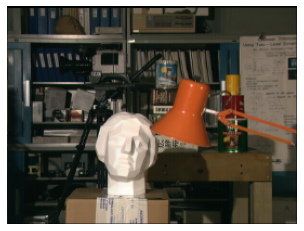

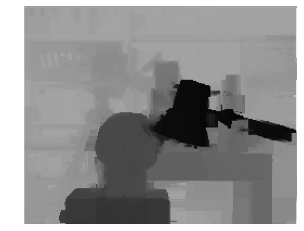

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D DEBUG] Input Points / Samples: 50652 / 50652
[Open3D DEBUG] #   Got kernel density: 0.0343471 (s), 1036.64 (MB) / 1036.64 (MB) / 1128 (MB)
[Open3D DEBUG] #     Got normal field: 0.130044 (s), 1037.67 (MB) / 1037.67 (MB) / 1128 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.894738e-05 / 1.972763e+00
[Open3D DEBUG] #       Finalized tree: 0.131718 (s), 1041.02 (MB) / 1041.02 (MB) / 1128 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.105670 (s), 1041.04 (MB) / 1041.04 (MB) / 1128 (MB)
[Open3D DEBUG] #Set point constraints: 0.0174658 (s), 1041.04 (MB) / 1041.04 (MB) / 1128 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 866559 / 604352 / 386001
[Open3D DEBUG] Memory Usage: 1041.043 MB
[Open3D DEBUG] # Linear system solved: 1.29912 (s), 1041.41 (MB) / 1041.41 (MB) / 1128 (MB)
[Open3D DEBUG] Got average: 0.0160830 (s

In [10]:
#img1 pointcloud
depth_map(imgL1, imgR1, 16, 5, 'ex1/')
pc = compute_pointCloud('ex1/color.png', 'ex1/disparity.png')
plot_pointCloud(pc)
plot_mesh(pc)


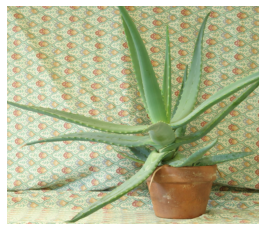

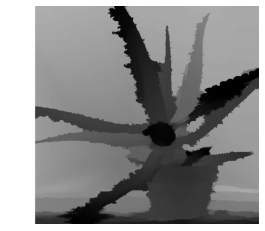

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D DEBUG] Input Points / Samples: 619269 / 247428
[Open3D DEBUG] #   Got kernel density: 0.0414169 (s), 691.613 (MB) / 691.613 (MB) / 691 (MB)
[Open3D DEBUG] #     Got normal field: 0.330029 (s), 741.238 (MB) / 741.238 (MB) / 741 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.139989e-06 / 1.944498e+00
[Open3D DEBUG] #       Finalized tree: 0.41916 (s), 808.895 (MB) / 808.895 (MB) / 808 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.308634 (s), 821.449 (MB) / 821.449 (MB) / 821 (MB)
[Open3D DEBUG] #Set point constraints: 0.0608141 (s), 824.188 (MB) / 824.188 (MB) / 824 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 2100813 / 2357232 / 43697
[Open3D DEBUG] Memory Us

In [9]:
# #img2 pointcloud
depth_map(imgL2, imgR2, 100, 11, 'ex2/')    #I tested multiple hyperparameters and think this is the best
pc = compute_pointCloud('ex2/color.png', 'ex2/disparity.png')
plot_pointCloud(pc)
plot_mesh(pc)


## References ##
[1] Tomasi, C., & Kanade, T. (1992). Shape and motion from image streams under orthography: A factorization method. International Journal of Computer Vision, 9(2), 137-154. doi:10.1007/bf00129684

[2] Poelman, C., & Kanade, T. (1997). A paraperspective factorization method for shape and motion recovery. IEEE Transactions on Pattern Analysis and Machine Intelligence, 19(3), 206-218. doi:10.1109/34.584098

[3] Han, X., Laga, H., & Bennamoun, M. (2019). Image-based 3D Object Reconstruction: State-of-the-Art and Trends in the Deep Learning Era. IEEE Transactions on Pattern Analysis and Machine Intelligence, 1-1. doi:10.1109/tpami.2019.2954885

[4] Dall’Asta, E., & Roncella, R. (2014). A COMPARISON OF SEMIGLOBAL AND LOCAL DENSE MATCHING ALGORITHMS FOR SURFACE RECONSTRUCTION. The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences, XL-5. doi:https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XL-5/187/2014/isprsarchives-XL-5-187-2014.pdf

[5] Padierna, O. (2019, January 2). Tutorial: Stereo 3D reconstruction with OpenCV using an iPhone camera. Part III. [Web log post]. Retrieved December 4, 2020, from https://medium.com/@omar.ps16/stereo-3d-reconstruction-with-opencv-using-an-iphone-camera-part-iii-95460d3eddf0

[6] Hirschmuller, H. (2008). Stereo Processing by Semiglobal Matching and Mutual Information. IEEE Transactions on Pattern Analysis and Machine Intelligence, 30(2), 328-341. doi:10.1109/tpami.2007.1166\

[7] Epipolar Geometry. (n.d.). Retrieved December 16, 2020, from https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html